In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from IPython.display import Math, display
show = lambda func: display(Math(func.__str__()))

In [4]:
def readAirfoil(file='airfoil.dat'): # NACA 44017 Airfoil cl=0.60 T=17.0% P=20.0%
    with open(file, 'r') as f:
        data = f.read().split('\n\n')
    shape = [[], []]
    for d in range(2):
        shape[d] = [[float(n.strip(' ')) for n in thing.split(' ') if n] for thing in data[d].split('\n') if thing]
    df = pd.DataFrame({'xb': [lis[0] for lis in shape[0]], 'top': [lis[1] for lis in shape[0]], 'bot': [lis[1] for lis in shape[1]]})
    return df.set_index('xb')
df = readAirfoil('NACA44017.dat')
# df.to_csv('aerofoil.csv')

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
df = readAirfoil('NACA44017.dat')
lin = LinearRegression()
poly = PolynomialFeatures(degree=len(df))
lin.fit(poly.fit_transform(df.index.to_numpy().reshape(-1, 1)), df[['top', 'bot']].values)
df[['ptop', 'pbot']] = lin.predict(poly.transform(df.index.to_numpy().reshape(-1, 1)))

<AxesSubplot:xlabel='xb'>

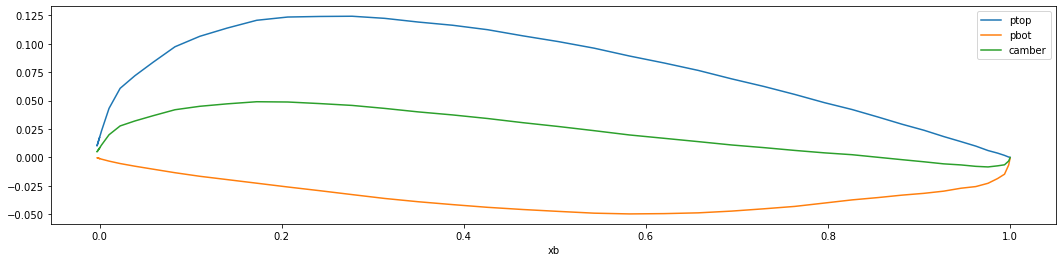

In [10]:
from MathFunctions import Poly as Polynomial
top, bot = [Polynomial([lin.intercept_[p] + lin.coef_[p][0]] + list(lin.coef_[p][1:]), symbol='\\left(\\frac{x}{c}\\right)') for p in range(2)]
camber = (top + bot) / 2
df['camber'] = [camber(i) for i in df.index]
df.plot(figsize=(18, 4), y=['ptop', 'pbot', 'camber'])

In [7]:
bot(0.7)

-0.04699441719240283

In [7]:
top.max(0.16, 0.4), bot.min(0.15, 0.4)
tmax, bmin, t15, b15 = top.max(0.16, 0.4), bot.min(0.15, 0.4), top(0.15), bot(0.15)
tsk, bsk = (tmax + t15) / 2, (bmin + b15) / 2
trans = camber(0.45)-(bmin+(tmax-bmin)/2)

coord = np.array([[0.15, bsk], [0.75, bsk], [0.75, tsk], [0.15, tsk], [0.15, bsk]]).T
df.plot(figsize=(18, 4), y=['top', 'bot', 'camber'])

plt.plot(coord[0], coord[1]+trans)
plt.ylabel('t/c [-]')
plt.xlabel('x/c [-]')
plt.savefig('windbox.jpg')
bsk, tsk

AttributeError: 'MathFunctions.Poly' object has no attribute 'max'

In [ ]:
xcoords = np.arange(0.15,0.751,0.001)
ycoordstop = np.array([top(x) for x in xcoords])
ycoordsbottom = np.array([bot(x) for x in xcoords])
df.plot(figsize=(18, 4), y=['top', 'bot', 'camber'])
plt.plot(xcoords, ycoordstop, color = 'red')
plt.plot(xcoords, ycoordsbottom, color = 'red')
plt.plot([0.15, 0.15], [top(0.15), bot(0.15)], [0.75, 0.75], [top(0.75), bot(0.75)], color = 'red')
plt.ylabel('t/c [-]')
plt.xlabel('x/c [-]')
plt.savefig('actual_windbox.jpg')
plt.show()


In [5]:
%%file Draw.py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from numpy import linspace

def PlotContour(xp, y, z, xtit, ytit, title, x):
    fig = go.Figure(data=go.Heatmap(
        x=xp,
        y=y,
        z=z,
        connectgaps=False,
        colorscale='Picnic',
        zsmooth='best'
    ), layout=go.Layout(
        xaxis=dict(title=xtit, autorange='reversed'),
        yaxis=dict(title=ytit),
        title=f'Cross Sectional {title} Stress Distribution at {x = } m'
    ))
    return fig

def NormalStressPlot(oxx, x, Ch, Ca, shape, tsk, **others):
    zi = list(linspace(Ch - Ca, Ch, 1200, dtype='float'))
    yi = list(linspace(-Ch, Ch, 600, dtype='float'))
    o_zy = [[None if abs(y_i) > shape(z_i) else oxx(z_i, y_i)(x)*1e-6 for z_i in zi] for y_i in yi]
    return PlotContour(zi, yi, o_zy,
        'Chordwise Distribution [m]',
        'Vertical Distribution [m]',
        'Normal', x)

def ShearStressPlot(oxx, x, Ch, Ca, shape, tsk, tsp, **others):
    zi = list(linspace(Ch - Ca, Ch, 1800, dtype='float'))
    yi = list(linspace(-Ch, Ch, 1200, dtype='float'))
    o_zy = [[None if abs(y_i) > shape(z_i) or (abs(y_i) < shape(z_i) - tsk and not -tsp < z_i < tsp) \
        else oxx(z_i, y_i)(x)*1e-6 for z_i in zi] for y_i in yi]
    return PlotContour(zi, yi, o_zy,
        'Chordwise Distribution [m]',
        'Vertical Distribution [m]',
        'Shear', x)

def InternalLoading(x0, x1, **Loads):
    titles = [k + f' [kN{"" if k[0].upper() == "V" else "m"}]' for k in Loads]
    fig = make_subplots(rows=len(list(Loads.keys())), cols=1, shared_xaxes=True, vertical_spacing=0.05)
    xs = linspace(x0, x1, 5000)
    for i, (li, load) in enumerate(zip(Loads.keys(), Loads.values())):
        fig.append_trace(go.Scatter(
            x=xs,
            y=[load(xi)*1e-3 for xi in xs],
            name=li,
        ), row=i+1, col=1)
        fig.update_yaxes(title_text=titles[i], row=i+1, col=1)

    fig.update_xaxes(title_text="Spanwise Position [meters]", row=len(Loads.keys()), col=1)
    fig.update_layout(
        title="Internal Load (NVM) Diagram",
        template="plotly_dark")

    return fig

def Deflections(x0, x1, pi, **defs):
    titles = [k + f' [{"millimeters" if k[0].lower() in ["w", "v"] else "degrees"}]' for k in defs]
    fig = make_subplots(rows=len(list(defs.keys())), cols=1, shared_xaxes=True, vertical_spacing=0.01)
    xs = linspace(x0, x1, 5000)
    for i, (li, load) in enumerate(zip(defs.keys(), defs.values())):
        fig.append_trace(go.Scatter(
            x=xs,
            y=[load(xi)*(180 / pi if 'degrees' in titles[i] else 1e3) for xi in xs],
            name=li,
        ), row=i+1, col=1)
        fig.update_yaxes(title_text=titles[i], row=i+1, col=1)

    fig.update_xaxes(title_text="Spanwise Position [meters]", row=len(defs.keys()), col=1)
    fig.update_layout(
        title="Deflection Diagram")

    return fig

def DrawFatigue(t, y):
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
    fig.append_trace(go.Scatter(
        x=t,
        y=y,
        name='Fatigue Cycle',
    ), row=1, col=1)
    fig.update_yaxes(title_text='Stress [MPa]', row=1, col=1)

    fig.update_xaxes(title_text="Time [hours]", row=1, col=1)
    fig.update_layout(template="plotly_dark", title='Fatigue Cycle')
    return fig

Overwriting Draw.py


In [1]:
%%file SolveLoads.py
from Geometry import Stringer, WingBox, WingStructure
from Equilibrium import PointLoad, Moment, RunningLoad, EquilibriumEquation, DistributedMoment
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from MathFunctions import StepFunction
import rainflow
import numpy as np
import pandas as pd


class Engines:
    def __init__(self, ThrustHover, ThrustCruise, positions: list[float, int], weight):
        self.n, self.Thover, self.Tcruise = len(positions), ThrustHover, ThrustCruise
        self.pos = positions
        self.w = weight
    __repr__ = __str__ = lambda self: "Engines(" + ', '.join(f"{k}={self.__dict__[k]}" for k in self.__dict__) + ")"

class WingLoads:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        self.wing, self.acp = [None]*2
        self.Fx, self.Fy, self.Fz, self.Mx, self.My, self.Mz = [None]*6
        self.RFx, self.RFy, self.RFz, self.RMx, self.RMy, self.RMz = [None]*6
        self.VFx, self.VMy, self.VMz = [None]*3
        self.ViVx, self.ViMy = [None]*2
        
        self.box = WingBox(self.tsk, self.tsp, self.frac, self.toc)
        self.box.StrPlacement(self.nStrT, self.nStrB, self.strGeo, self.strType)
        self.wing = WingStructure(self.span, self.taper, self.cr, self.box)
        self.acp = (self.xac - 0.45) * self.mac # Redefine
        
    def __setitem__(self, key, item):
        self.__dict__[key] = item

    __getitem__ = lambda self, key: self.__dict__[key]
    
    mass = lambda self, material: self.span * self.wing(0).Area() * material.rho * 2

    __repr__ = __str__ = lambda self: "Wingloads(" + ', '.join(f"{k}={self.__dict__[k]}" for k in self.__dict__) + ")"

    def equilibriumCruise(self, dragDistr, liftDistr, macDistr, wingWeight):
        acp = self.acp
        Thrusts = [PointLoad([-self.engines.Tcruise, -self.engines.w, 0], [-0.45*self.wing(p).b/self.frac, 0, p]) \
                   for p in self.engines.pos] # Redefine x, y
        Drag = RunningLoad([dragDistr[1], [0]*len(dragDistr[1])], dragDistr[0], axis=2, poa=(acp, 0))
        Lift = RunningLoad([[0]*len(liftDistr[1]), liftDistr[1]], liftDistr[0], axis=2, poa=(acp, 0))
        Mac = DistributedMoment(values=[[0, 0, mom] for mom in macDistr[1]], positions=macDistr[0])
        weights = RunningLoad(values=[[0]*2, [-wingWeight / self.span]*2], positions=[0, self.span/2], axis=2)
        eqn = EquilibriumEquation(kloads=[Lift, weights, Drag, Mac] + Thrusts,
                                 ukloads=[PointLoad([1, 0, 0], [0, 0, 0]), PointLoad([0, 1, 0], [0, 0, 0]),
                                          PointLoad([0, 0, 1], [0, 0, 0]), Moment([1, 0, 0]),
                                          Moment([0, 1, 0]), Moment([0, 0, 1])])
#         print(Lift.force()*4, Drag.force(), 3024.8012022968796*9.81)
        eqn.SetupEquation()
        self.RFx, self.RFy, self.RFz, self.RMx, self.RMy, self.RMz = solved = eqn.SolveEquation()
        return solved
    
    def equilibriumVTO(self, wingWeight, ground = False):
        Thrusts = [PointLoad([(-self.engines.Thover if not ground else 0) + self.engines.w, 0, 0],
                             [-0.45*self.wing(p).b/self.frac, 0, p]) for p in self.engines.pos] # Redefine x, y
        weights = RunningLoad(values=[[wingWeight / self.span]*2, [0]*2], positions=[0, self.span/2], axis=2)
        eqtn = EquilibriumEquation(kloads=[weights] + Thrusts,
                                  ukloads=[PointLoad([1, 0, 0], [0, 0, 0]), Moment([0, 1, 0]), Moment([0, 0, 1])])
        eqtn.SetupEquation()
        self.VFx, self.VMy, self.VMz = eqtn.SolveEquation()
        return self.VFx, self.VMy, self.VMz
    
    def internalLoads(self, dragDistr, liftDistr, macDistr, wingWeight):
        if not any([self.RFx, self.RFy, self.RFz, self.RMx, self.RMy, self.RMz]):
            self.equilibriumCruise(dragDistr, liftDistr, macDistr, wingWeight)

        lin = LinearRegression()
        poly = PolynomialFeatures(degree=len(liftDistr))
        X = poly.fit_transform(dragDistr[0].reshape(-1, 1))
        lin.fit(X, np.array([dragDistr[1], liftDistr[1], macDistr[1]]).T)
        dragcoef, liftcoef, momcoef = lin.coef_
        interd, interl, interm = lin.intercept_
    
        drag = StepFunction([[dragcoef[i], 0, i] for i in range(len(dragcoef))] + [[interd, 0, 0]])
        lift = StepFunction([[liftcoef[i], 0, i] for i in range(len(liftcoef))] + [[interl, 0, 0]])
        Mac = StepFunction([[momcoef[i], 0, i] for i in range(len(momcoef))] + [[interm, 0, 0]])
        Thrust = StepFunction([[-self.engines.Tcruise, p, 0] for p in self.engines.pos])
        ThrustW = StepFunction([[-self.engines.w, p, 0] for p in self.engines.pos])
        MThrust = StepFunction([[0.45*self.wing(p).b * self.engines.w / self.frac, p, 0] for p in self.engines.pos])
    
        wgt = StepFunction([[-wingWeight / self.span, 0, 0]])
        self.Vy = -(lift + wgt).integral(self.RFy) - ThrustW
        self.Vx = -(Thrust + drag.integral(self.RFx))
        self.T = -(Mac + lift * self.acp).integral(self.RMz) - MThrust
        self.My, self.Mx = self.Vx.integral(self.RMy), self.Vy.integral(-self.RMx)
        return lift, wgt

    def internalLoadsVTO(self, wingWeight, ground = False):
        wgt = StepFunction([[wingWeight / self.span, 0, 0]]) # Fx
        Thrusts = StepFunction([[(-self.engines.Thover if not ground else 0)+self.engines.w, p, 0] for p in self.engines.pos]) # Fx
        self.ViVx = Vx = -(Thrusts + wgt.integral(self.VFx))
        self.ViMy = My = Vx.integral(self.VMy)
        return Vx, My
    
    def stressesCruise(self, point=0):
        root = self.wing(point)
        # q, tau, o
        coordinates = [[x, root.h/2] for x in np.linspace(-root.b/2, root.b/2, 1000)] + [[root.b/2, y] for y in np.linspace(root.h/2, -root.h/2, 1000)] \
        + [[x, -root.h/2] for x in np.linspace(-root.b/2, root.b/2, 1000)] + [[-root.b/2, y] for y in np.linspace(root.h/2, -root.h/2, 1000)]
        
        x, y = np.array(coordinates).T
        sigma = root.o(x, y, self.Mx(0), self.My(0))
        tau = np.array([root.tau(ix, iy, self.Vx(0), self.Vy(0), self.T(0)) for ix, iy in coordinates])
        
        return np.array(coordinates), sigma, tau, np.sqrt(3*tau**2 + sigma**2)

    def stressesVTO(self, point=0):
        root = self.wing(point)
        # q, tau, o
        coordinates = [[x, root.h/2] for x in np.linspace(-root.b/2, root.b/2, 1000)] + [[root.b/2, y] for y in np.linspace(root.h/2, -root.h/2, 1000)] \
        + [[x, -root.h/2] for x in np.linspace(-root.b/2, root.b/2, 1000)] + [[-root.b/2, y] for y in np.linspace(root.h/2, -root.h/2, 1000)]
        
        x, y = np.array(coordinates).T
        sigma = root.o(x, y, Mx = 0, My = self.ViMy(0))
        tau = np.array([root.tau(ix, iy, Vx = self.ViVx(0), Vy = 0, T = 0) for ix, iy in coordinates])
        return np.array(coordinates), sigma, tau, np.sqrt(3*tau**2 + sigma**2)
    
    def LugLoad(self):
        eqf = self.RMz / self.wing(0).b
        FmaxN = self.RFy / 2 + eqf
        eqmx = self.RMy / self.wing(0).b
        FmaxT = eqmx
        return [FmaxN / 2, FmaxT / 2]
    
    @staticmethod
    def extreme(coord, arr):
        h, l = np.argmax(arr), np.argmin(arr)
        return ([coord[l], arr[l]], [coord[h], arr[h]])

class Lug:
    def __init__(self, a, c, d, t, mat=7075):
        self.a, self.c, self.d, self.t = a, c, d, t
        self.b, self.m = (6.0, -0.020803428405001143) if mat == 7075 else (5.929411764705884, -0.011764705882352944)
        self.density = 2810
        self.mat = mat
        self.k1, self.k2 = (a * d / (c ** 2)) ** 0.5, (10 / d) ** 0.2

    Kt = lambda self: 3.8 * (self.c / self.a) ** 0.2 * (self.c / self.d) ** 0.5
    
    def stress(self, F):
        reflug = ReferenceLug(self.t, self.mat)
        Sref = reflug.stress(F)
        N = reflug.SN(Sref)
        theta = 0.25 * np.log10(N) - 0.5 if 1e3 <= N <= 1e6 else 1
        return Sref * (1 + theta * (self.k1 * self.k2 - 1))
    
    Ka = lambda self, alpha: alpha * (0.007 * self.c / self.a - 0.008) + 1
    
    mass = lambda self, L: 1e-9 * self.t * self.density * (np.pi * ((self.a + self.d / 2) ** 2 - self.d ** 2 / 4) + L * (2 * self.c + self.d))
    
    Fatigue = lambda self, F, alpha=0: self.SN(self.Kt() * self.Ka(alpha) * self.stress(F))

    SN = lambda self, S: 10 ** (self.b + S * self.m)

    __repr__ = __str__ = lambda self: "Lug(" + ', '.join(f"{k}={self.__dict__[k]}" for k in self.__dict__) + ")"


class ReferenceLug(Lug):
    def __init__(self, t, mat=7075):
        super().__init__(*([10]*3 + [t, mat]))
    
    stress = lambda self, F, alpha=0: F /  (2 * self.c * self.t)


class Fatigue:
    def __init__(self, Sground, Stakeoff, Scruise, airTime, turnOver, takeOffTime, mat):
        self.Sg, self.Sto, self.Scr, self.tAir, self.tTO = Sground, Stakeoff, Scruise, airTime, takeOffTime
        self.tot = turnOver
        self.cyc, self.df, self.ts = [None]*3
        self.mat = mat

    def determineCycle(self):
        self.ts = np.linspace(0, self.tAir + self.tot, 1000)
        gag, tg = [], self.tot / 2
        for t in self.ts:
            acoustic = 0.05 * np.sum(np.sin(2*np.pi * t / np.arange(0.001/3600, 0.01/3600, 0.001/3600))) # noise in the given frequency range
            turbulence = 0.1 * np.sum(np.sin(2*np.pi * t / np.arange(0.1/3600, 10/3600, 0.1/3600))) # same here
            taxi = 0.1 * np.sum(np.sin(2*np.pi * t / np.arange(0.05/3600, 1/3600, 0.05/3600))) # and here, all frequencies taken from the textbook - Schijve Ch 9
            if t < tg or t > self.tAir + tg:
                gag.append(self.Sg + (taxi if tg > t > 0.5 * tg or self.tAir + tg < t < self.tAir + 1.5 * tg else 0))
            elif tg + 0.5 <= t <= self.tAir + tg - 0.5:
                gag.append(self.Scr + acoustic + (turbulence if tg + 1 > t or t > self.tAir + tg - 1 else 0))
            else:
                gag.append(self.Sto + acoustic + turbulence)
        self.cyc = np.array(gag)
        return self.ts, self.cyc

    def getCycles(self):
        df = pd.DataFrame(data=list(rainflow.extract_cycles(self.cyc)),
                              columns='dS, Sm, count, ti, tf'.split(', '))
        df['Smax'] = df['Sm'] + df['dS'] / 2
        df['Smin'] = df['Sm'] - df['dS'] / 2
        df = df[df['Smax'] != 0]
        self.df = df[df['count'] != 0]
        return self.df
    
    def MinersRule(self):
        Ns = np.array([self.mat.BasquinLaw(dS) for dS in self.df.dS])
        nCycles = self.df['count'] / Ns
        return 1 / nCycles.sum()
    
    def CrackGrowth(self, a0, w, Nflights):
        length = a0
        step = 1000
        for j in range(0, Nflights, step):
            da = min(step, Nflights - j) * self.mat.ParisFatigueda(length, w,
                                self.df['Smax'].values, self.df['Smin'].values,
                                                                   self.df['count'].values).sum()
            if length >= w / 2:
                break
            length += da
        return length, j
    


Overwriting SolveLoads.py


## SN curve lug

source: https://p300.zlibcdn.com/dtoken/2f0583d4051bf43f62ca1e92788bf1cf 

LARSSON
https://repository.tudelft.nl/islandora/object/uuid:3be70155-068a-4f41-8397-2a0bb71db5d3/datastream/OBJ/download Ka

In [141]:
Skgmm, Nlog = np.array([[9.8, 4], [4.9, 5]]).T
S = Skgmm * 9.81
N = 10 ** Nlog
A = np.array([[1, 1], S]).T
b, a = np.linalg.inv(A) @ Nlog
b, a

(6.0, -0.020803428405001143)

In [142]:
S, Nlog = np.array([[79, 5], [45, 5.4]]).T
N = 10 ** Nlog
A = np.array([[1, 1], S]).T
b, a = np.linalg.inv(A) @ Nlog
b, a

(5.929411764705884, -0.011764705882352944)

In [187]:
almostEqual = lambda n1, n2, places=2: abs(n1 - n2) <= 10 ** (-places)
def testlug():
    a5 = Lug(5, 10, 10, 5, 7075)
    print(a5.stress(800), a5.Kt())
    assert almostEqual(a5.k2, 1)
    assert almostEqual(a5.k1, 0.707)
    assert almostEqual(a5.stress(800), 8.731, 1), "Not True: 8.731 = " + str(a5.stress(800))

In [188]:
print(ReferenceLug(5, 7075).stress(1000))
testlug()

10.0
5.754345179218717 4.365053748988733


AssertionError: Not True: 8.731 = 5.754345179218717

## Analysis

In [53]:
from cg_est import *

b = (14 * 5.25) ** 0.5

args = dict(span=b, taper=0.4, cr=0.5, tsk=1e-3, tsp=1e-2,
            toc=0.17, nStrT=5, nStrB=3, StrA=1e-4, mac=0.65, xac=0.25,
            engines=Engines(2960, 2960, list(np.linspace(0.1*b/2, 0.8*b/2, 4)), 400 * 9.81 / 8),
           frac=0.6)

loads = WingLoads(**args)

config = 1
WoS = 1745
Pmax = 8.77182
mProp = 400 / 16
thickness = 3e-3
w_fus= 1.3; h_fus=1.6; l_fus=4
nmax = 3.2
mTO = 1800

# w = Weight(self.m_pax, wing, fuselage, lgear, props,
#                    cargo_m = self.cargo_m, cargo_pos = self.cargo_pos, battery_m = self.battery_m,
#                    battery_pos = self.battery_pos, p_pax = self.p_pax)

w = Weight(95, Wing(mTO, 5.25, 5.25, 1.5*nmax, 14, [0.4, 3.6], config),
           Fuselage(mTO, Pmax, l_fus, 5, l_fus/2, config),
          LandingGear(mTO, l_fus/2),
          Propulsion(16, [mProp]*16, pos_prop=[3.6]*int(8) + [0.4]*int(8)),
          85, 3, 483.15, l_fus/2, [0.8, 1.3, 1.3, 2.5, 2.5])

wingWeight = w.wing.get_weight()[0] * 9.81
lift = nmax * 1.5 * w.mtom * 9.81
drag = lift / 19.03
pos = np.linspace(0, b/2, 10000)
dragd = 2 * drag / (np.pi * b) * np.sqrt(1 - 4 * np.power(pos / b, 2))
liftd = 2 * lift / (np.pi * b) * np.sqrt(1 - 4 * np.power(pos / b, 2))
Mac = 0.0645 * 0.5 * 1.2 * 53 ** 2 * 5.25 * 0.65

solved = loads.equilibriumCruise([pos, dragd], [pos, liftd], [pos, [Mac / b]*len(pos)], wingWeight)

lift, wgt = loads.internalLoads([pos, dragd], [pos, liftd], [pos, [Mac / b]*len(pos)], wingWeight)
# InternalLoading(0, b/2, **{l: loads[l] for l in 'T, My, Mx, Vx, Vy'.split(', ')}).show(renderer='iframe')

AttributeError: 'WingLoads' object has no attribute 'strGeo'

In [ ]:
print(loads.equilibriumVTO(wingWeight))
# loads.internalLoadsVTO(wingWeight)

# InternalLoading(0, b/2, Vx = loads['ViVx'], My = loads.ViMy).show(renderer='iframe')
coords, ocruise, taucruise = loads.stressesCruise()
print(WingLoads.extreme(coords, ocruise), WingLoads.extreme(coords, taucruise))
print(loads.wing(0).b, loads.wing(0).h)

# -2.67697664e+08
# -2.44490788e+08

In [2]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
xs = pos
fig.append_trace(go.Scatter(
    x=xs,
    y=liftd,
    name='Lift',
), row=1, col=1)
fig.append_trace(go.Scatter(
    x=xs,
    y=[lift(k) for k in pos],
    name='Lift Approximation',
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=xs,
    y=[wingWeight / b]*len(pos),
    name='Weight',
), row=1, col=1)

fig.update_yaxes(title_text='Lift [N]', row=1, col=1)

fig.update_xaxes(title_text="Spanwise Position [meters]", row=1, col=1)
fig.update_layout(
    title="Lift vs Weight",
    template="plotly_dark")
fig.show(renderer='iframe')

NameError: name 'make_subplots' is not defined

In [2]:
import rainflow

time = np.array([4.0 * i / 200 for i in range(200 + 1)])
signal = 5 + 100 * np.sin(time) + 500 * np.cos(10*time) + 200 * np.sin(4*time)

cycles = pd.DataFrame(data=list(rainflow.extract_cycles(signal)),
                      columns='dS, Sm, cycles, ti, tf'.split(', '))
cycles

,dS,Sm,cycles,ti,tf
0,8.016094,509.008047,0.5,0,1
1,787.052505,119.489842,0.5,1,15
2,958.285827,205.106503,0.5,15,31
3,811.292589,4.917277,1.0,63,78
4,1218.273936,75.112448,0.5,31,48
5,752.477060,75.405868,1.0,111,125
6,1322.617243,127.284102,0.5,48,94
7,844.045448,87.402351,1.0,158,173
8,1442.568773,67.308337,0.5,94,141
9,1222.426104,-42.762998,0.5,141,188


In [47]:
from Material import Material
fatigue = Fatigue(0, 0, 100, 4, 2, 0.5, Material.load(file = '../data/materials.csv'))
t, y = fatigue.determineCycle()
fatigue.getCycles()
fatigue.MinersRule()
fatigue.CrackGrowth(0.1e-3, 1, 100000000)

(0.5002526652069931, 44944000)

In [21]:
fatigue.df = fatigue.df[fatigue.df['dS'] > 80]

In [22]:
fatigue.df = pd.DataFrame({'dS': [400, 140],
                           'count': [0.5 * fatigue.mat.BasquinLaw(400), 1.54 * fatigue.mat.BasquinLaw(140)]})
1 / 

2.04

In [23]:
fatigue.mat.BasquinLaw(140)

819970.8454810496

In [24]:
fatigue.mat.BasquinLaw(400)

12304.6875

$f = \Sigma_{k=1}^n \frac{N_k}{n_k}$

In [ ]:
fatigue.df

In [2]:
from Geometry import Wingbox

ImportError: cannot import name 'Wingbox' from 'Geometry' (/home/ec2-user/DSE/structures/Geometry.py)